# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

### Problem background

The City of New York, is the most populous city in the United States. It is diverse and is the financial capital of USA. It is multicultural. It provides lot of business oppourtunities and business friendly environment. It has attracted many different players into the market. It is a global hub of business and commerce. The city is a major center for banking and finance, retailing, world trade, transportation, tourism, real estate, new media, traditional media, advertising, legal services, accountancy, insurance, theater, fashion, and the arts in the United States.

This also means that the market is highly competitive. As it is highly developed city the cost of doing business is also one of the highest. Thus, any new business venture or expansion needs to be analysed carefully. The insights derived from analysis will give good understanding of the business environment which help in strategically targeting the market. This will help in reduction of risk. And the Return on Investment will be reasonable.

### Problem Description

Throughout its history, New York City has been a major point of entry for immigrants; the term “melting pot” was coined to describe densely populated immigrant neighbourhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighbourhoods such as Flushing, Sunset Park, and Corona.

With New York's diverse culture , comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese ,Italian, Indian , French etc. So as part of this project , we will list and visualise all major parts of New York City that has great Italian restaurants.


### Target Audience

To recommend the correct location, AH Food Company Ltd has appointed me to lead of the Data Science team. The objective is to locate and recommend to the management which neighborhood of New York city will be best choice to start a Italian Restaurant. 


## Data <a name="data"></a>

For this project, we will be using the following Data:

1) New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Which can be found at: https://cocl.us/new_york_dataset

2) Use the FourSquare API to find and filter all the Italian restaurants to find the Boroughs and Neighborhoods that have the least Italian Restaurants

3) Use Borough Boundries data for the use of helpful maps found at https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

4) use the Demographic Data to find the boroughs and neighborhood with the most population at https://en.wikipedia.org/wiki/Demographics_of_New_York_City

## Methodology <a name="methodology"></a>

1) Get the boroughs and neighborhoods in NYC using the New York Dataset

2) Get the Italian Restaurants in NYC using FourSquare API

3) Select which borough based on the Demographics of NYC Wikipedia Page

4) Select Neighborhoods based on ratings, likes, tips of existing restaurants using FourSquare API

#### Step 1: Import necessary libraries

In [ ]:
!pip install pandas
!pip install requests
!pip install BeautifulSoup4
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
!pip install folium
import folium 
!pip install geopy
from geopy.geocoders import Nominatim 
!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
!pip install seaborn
import seaborn as sns

print('Done!')

In [ ]:
!python -m pip install --upgrade pip

In [ ]:
CLIENT_ID = 'T302E55OTYQ2DMTXO3REALHEQKKMP5YJ404G5JAVKJMG1EZB'
CLIENT_SECRET = 'DVVBHG31HONHGFZH5VAG0VMLA2LZFUCKD31QGIZRP3C41UPC'
VERSION = '20180605'

#### Step 2 : Making the New York DF with boroughs, neighborhoods and Coordinates

In [ ]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

In [ ]:
!pip install json
import json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [ ]:
ny_data = newyork_data['features']

In [179]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
new_york_data = pd.DataFrame(columns=column_names)

for data in ny_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [181]:
print('New York City has {} boroughs and {} neighborhoods.'.format(
        len(new_york_data['Borough'].unique()),
        new_york_data.shape[0]
    )
)

New York City has 5 boroughs and 306 neighborhoods.


Let us try to visualize this.

In [182]:
addres = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(addres)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [183]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_york_data['Latitude'], new_york_data['Longitude'], new_york_data['Borough'], new_york_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Step 3 : Getting the italian restaurant details into a dataframe

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,  
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Venue',
                  'Venue ID',
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
ny_venues = getNearbyVenues(names=new_york_data['Neighborhood'],latitudes=new_york_data['Latitude'],longitudes=new_york_data['Longitude'])

In [ ]:
ny_ir = ny_venues[ny_venues['Venue Category']=='Italian Restaurant']
ny_ir.head().reset_index(drop=True)

In [184]:
ny_ir.shape

(315, 4)

We can see that there are 315 italian restaurants in NYC, let us see try to visulaize this

In [ ]:
#to merge ny_ir and new_york_data
ny_data1 = pd.merge(new_york_data,ny_ir,on=['Neighborhood'])

In [185]:
ny_data1.head()

,Borough,Neighborhood,Latitude,Longitude,Venue,Venue ID,Venue Category
0,Bronx,Woodlawn,40.898273,-73.867315,Patrizia's Of Woodlawn,511edb6de4b0d58346fd272d,Italian Restaurant
1,Bronx,Pelham Parkway,40.857413,-73.854756,Enzo's,4bf96ae65317a593d837017f,Italian Restaurant
2,Bronx,Pelham Parkway,40.857413,-73.854756,Pasta Pasta,4b47f069f964a5208c4426e3,Italian Restaurant
3,Bronx,City Island,40.847247,-73.786488,Artie's Steak and Seafood,4514ed4df964a520e5391fe3,Italian Restaurant
4,Bronx,Fordham,40.860997,-73.896427,Boca Restaurant And Lounge,5bb35ead2aff310039539a62,Italian Restaurant


In [186]:
ny_data1.dropna()
ny_data1.shape

(326, 7)

In [ ]:
ny_data1.groupby('Borough')['Venue'].count()

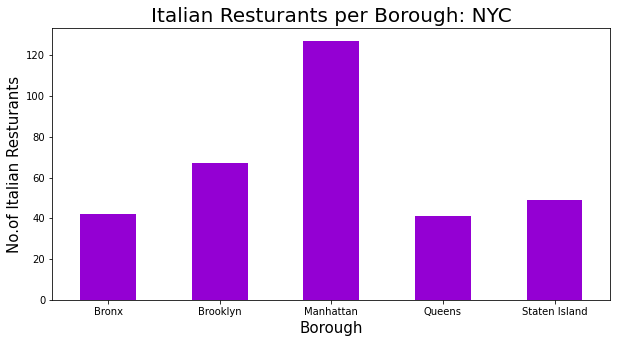

In [187]:
ny_data1.groupby('Borough')['Venue'].count().plot.bar(figsize=(10,5), color = '#9400D3')
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Let us also see the top neighborhoods in terms of number of Italian Restaurants

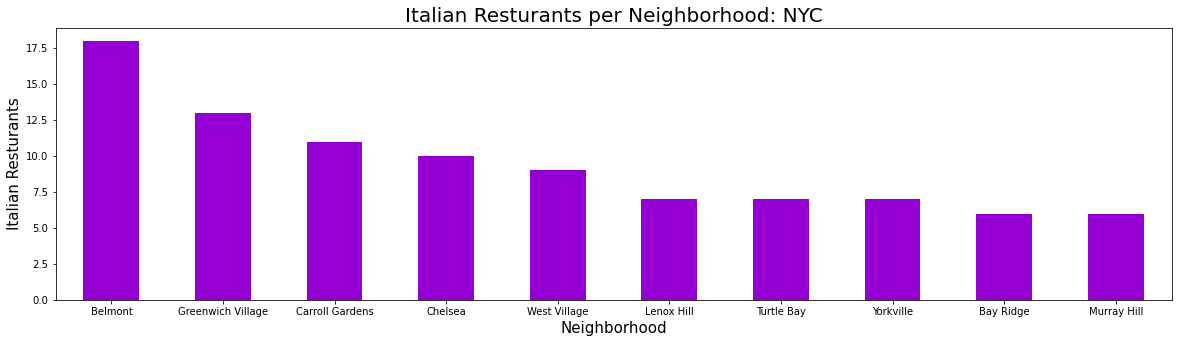

In [188]:
Num = 10 # top number for graphing all the same past 6
ny_data1.groupby('Neighborhood')['Venue'].count().nlargest(Num).plot.bar(figsize=(20,5), color='#9400D3')
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

##### Inference 1 :  Manhattan is the Borough with the most number of restaurants(127) and Belmont, Bronx is the Neighborhood with the most number of Restaurants(18) . Queens has the least number of restaurants (41)

## Analysis <a name="analysis"></a>

#### Step 1 : Get the population data for each borough so that we can select a borough

In [ ]:
url = 'https://en.wikipedia.org/wiki/Demographics_of_New_York_City'
demo=requests.get(url).text
from bs4 import BeautifulSoup
soup = BeautifulSoup(demo, 'html.parser')

print(soup.prettify())

In [ ]:
table = soup.find( "table", {"class":"wikitable sortable"} )
table

In [ ]:
def tableDataText(table):    
    """Parses a html segment started with tag <table> followed 
    by multiple <tr> (table rows) and inner <td> (table data) tags. 
    It returns a list of rows with inner columns. 
    Accepts only one <th> (table header/data) in the first row.
    """
    def rowgetDataText(tr, coltag='td'): # td (data) or th (header)       
        return [td.get_text(strip=True) for td in tr.find_all(coltag)]  
    rows = []
    trs = table.find_all('tr')
    headerow = rowgetDataText(trs[0], 'th')
    if headerow: # if there is a header row include first
        rows.append(headerow)
        trs = trs[1:]
    for tr in trs: # for every table row
        rows.append(rowgetDataText(tr, 'td') ) # data row       
    return rows

In [ ]:
list_table = tableDataText(table)
list_table

In [ ]:
dftable = pd.DataFrame(list_table[3:8],columns=['Borough','County','Estimate','billions','per capita','sqmiles','sqkm','persons/sqmiles','persons/sqkm'])
dftable

In [ ]:
dftable1 = dftable[['Borough','Estimate','per capita']]
dftable1

In [189]:
dftable1.rename(columns={'Estimate':'Population'},inplace=True)
dftable1

c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Borough,Population,per capita
0,The Bronx,"1,432,132","29,200"
1,Brooklyn,"2,582,830","34,600"
2,Manhattan,"1,628,701","360,900"
3,Queens,"2,278,906","39,600"
4,Staten Island,"476,179","30,300"


##### Inference 2 : We will select queens as our Borough to build a new italian restaurant as it has the second highest population and per capita income which means  a lot of people will be able to go out and spend their money. (from inference 1: queens has least no of italian restaurants)

#### Step 2 : Get ratings of all italian restaurants in queens so that we can select a neighborhood

In [ ]:
ny_data1.head()

In [ ]:
ny_queens = ny_data1[ny_data1['Borough']=='Queens']
ny_queens = ny_queens.reset_index(drop=True)
ny_queens

In [ ]:

ny_queens.drop(columns=['Venue Category'],inplace=True)
#ny_queens.reset_index(drop=True)
ny_queens

In [ ]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    print(results)
    
    venue_data=results["response"]
    venue_details=[]
    
    try:
        venue_id=venue_data['venue']['id']
        venue_name=venue_data['venue']['name']
        venue_likes=venue_data['venue']['likes']['count']
        venue_rating=venue_data['venue']['rating']
        venue_tips=venue_data['venue']['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    
    return df

In [ ]:
ny_queens_ratings=pd.DataFrame(columns=column_names)
count=1
for row in ny_queens.values.tolist():
    Neighborhood,Venue,ID=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        
    print('(',count,'/',len(ny_queens),')','processed')
    ny_queens_ratings = ny_queens_ratings.append({'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1


In [194]:
#ny_queens_ratings.drop(columns=['Borough','Latitude','Longitude'],inplace=True)
ny_queens_ratings

,Neighborhood,ID,Likes,Name,Rating,Tips
0,Murray Hill,4afa15d8f964a520931622e3,38.0,Villa Berulia,8.5,13.0
1,Murray Hill,4b3c0273f964a520488025e3,54.0,Rossinis,7.9,21.0
2,Murray Hill,4d99cbdc7cfc145660ac49f6,250.0,Piccolo Cafe,7.9,115.0
3,Astoria,5010b169e4b05edd9983ec7d,72.0,Antika Restaurant & Pizzeria,8.2,31.0
4,Astoria,4ebf0e380aaf6450ba608920,57.0,Via Trenta,7.5,28.0
5,Jackson Heights,4a82d6adf964a5206ff91fe3,42.0,Uncle Peter's,8.8,11.0
6,Howard Beach,4bafdb5df964a52086263ce3,35.0,Prima Pasta & Cafe,7.7,17.0
7,Howard Beach,4bae3bd0f964a52009963be3,9.0,Brothers Ravioli,7.7,2.0
8,Howard Beach,4ba148f5f964a5201da937e3,16.0,Roma View Catering,7.0,3.0
9,Corona,4b808501f964a5207b7930e3,187.0,Park Side,8.8,78.0


Let us average out the ratings by neighborhood

In [ ]:
ny_queens_stats=ny_queens_ratings.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_queens_stats.columns=['Neighborhood','Average Rating']
ny_queens_stats.sort_values(['Average Rating'],ascending=False).head()

In [ ]:
nyqs = ny_queens_stats.sort_values(['Average Rating'],ascending=False)
nyqs['Neighborhood'] = nyqs['Neighborhood'].astype(str)
nyqs.shape


In [198]:
nyqs
nyqs = nyqs[nyqs['Average Rating'] <= 8.0]
nyqs

,Neighborhood,Average Rating
22,Ridgewood,8.000000
0,Astoria,7.850000
11,Howard Beach,7.466667
3,Bayside,7.450000
15,Little Neck,7.233333
14,Kew Gardens,7.200000
24,Sunnyside,7.166667
17,Maspeth,7.100000
9,Douglaston,7.000000
1,Astoria Heights,6.900000


Let us plot a bar chart for this data

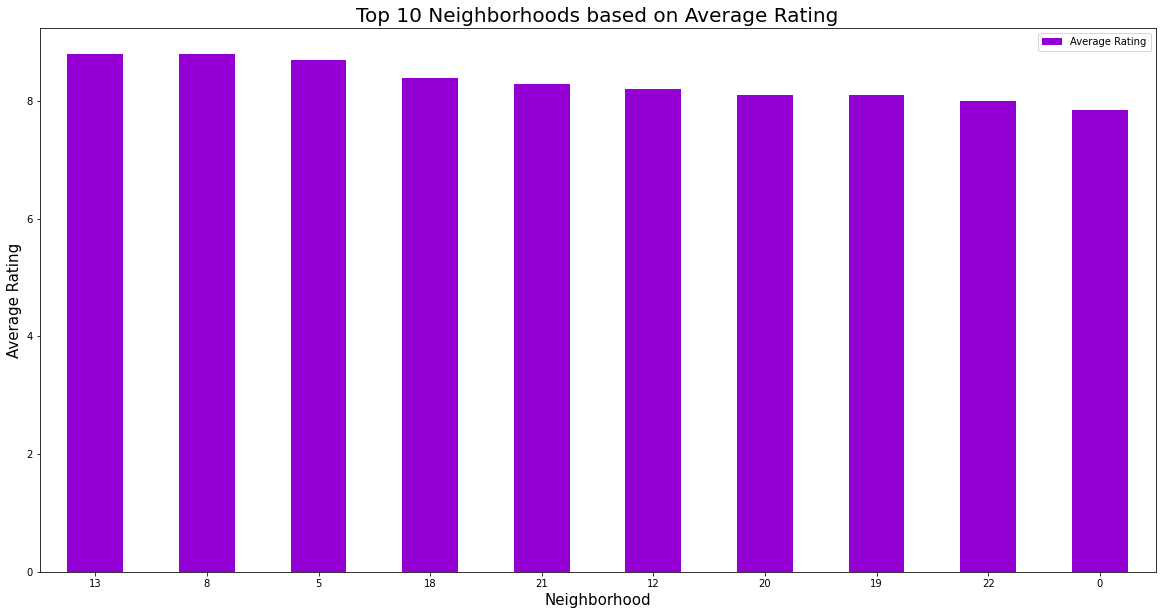

In [192]:
nyqs.nlargest(10,columns=['Average Rating']).plot.bar(figsize=(20,10), color='#9400D3')
plt.title('Top 10 Neighborhoods based on Average Rating', fontsize=20)
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

##### Inference 3 : Looking at the above data we can come to the conclusion that there are a number good neighborhoods to build a restaurant as there is only one other chain present and will provide a good setting for the new restaurant to be built.

## Results and Discussion <a name="results"></a>

Our Data shows that there a huge number of Italian Restaurants spread across all five boroughs in NYC, around 315 in total. Looking at the distribution, We found out that Manhattan had the highest number of Italian Restaurants, 127, and Queens had the lowest number of restaurants, 41. This statistic made me realize Queens as the Borough to pick for building the new restaurant.

As only one statistic is not enough, we looked at the Demographics of NYC to determine the population and per capita income per borough as both relate to how many customers the restaurant gets. We found out that Queens had the second highest population in NYC, 2,278,906, and the second highest per capita income, $39,600 which makes it an ideal spot to open a new restaurant.

We then found out which Neighborhood in Queens have Italian restaurants and we also looked at the average rating of these restaurants based on their neighborhood. Based on this and the number of Italian Restaurants in each neighborhood, the are a number of ideal locations where the stakeholders can choose to build a restaurant. They are: 

**Ridgewood, Kew Gardens , Maspeth , Douglaston , Astoria Heights , Long Island City , Steinway , Forest Hills , Beechhurst and Belle Harbor**

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify NYC areas with low number of restaurants (particularly Italian restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new Italian restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.